The notebook is for analyzing coarse-grained vorticity budget terms. The terms are coarse-grained using kernel of fixed size in km as well as in degrees. The coarse-graining is performed for different kernel sizes. The results are compared.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import xesmf as xe
import gcm_filters
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

Client Scheduler: tcp://127.0.0.1:37421 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 405.20 GB


In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-80,81,20))
    #gl.xlocator = mticker.FixedLocator(np.arange(-170,180,60))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [43]:
ppdir = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/Coarse_grain/All_Mean/"

ds_km = []
ds_deg = []

for i in range(100, 1050, 100):
    ds = xr.open_dataset(ppdir + "km_filter/filter_" + str(i) + "km.nc")
    ds_km.append(ds)
    
ds_km = xr.concat(ds_km, dim='filter_scale')
ds_km = ds_km.isel(time=0, depth=0)

for i in range(1, 18):
    ds = xr.open_dataset(ppdir + "degree_filter/filter_" + str(i/1000) + "km.nc")
    ds_deg.append(ds)
    
ds_deg = xr.concat(ds_deg, dim='filter_scale')
ds_deg = ds_deg.isel(time=0, depth=0)

In [44]:
print(ds_deg)

<xarray.Dataset>
Dimensions:     (filter_scale: 17, latitude: 720, longitude: 1440)
Coordinates:
    time        float64 0.0
    depth       float64 0.0
  * latitude    (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude   (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: filter_scale
Data variables:
    cell_areas  (filter_scale, latitude, longitude) float64 0.0625 ... 0.0625
    beta_V      (filter_scale, latitude, longitude) float32 0.0 ... 2.0388552...
    BPT         (filter_scale, latitude, longitude) float32 0.0 ... 2.6026328...
    Mass_flux   (filter_scale, latitude, longitude) float32 0.0 ... 1.282047e-12
    eta_dt      (filter_scale, latitude, longitude) float32 0.0 ... -7.079460...
    Curl_dudt   (filter_scale, latitude, longitude) float32 5.551115e-17 ... ...
    Curl_taus   (filter_scale, latitude, longitude) float32 -1.3877788e-17 .....
    Curl_taub   (filter_scale, latitude, longitude) float32 0.0 .

In [62]:
# Put mask values
ppdir1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"
ds_wet = xr.open_dataset(ppdir1 + "OM4p25_JRA55_Vorticity_Budget_LatLon.nc")
ds_wet = ds_wet.rename({'x': 'longitude', 'y': 'latitude'})

ds_mask = ds_deg['beta_V'].isel(filter_scale=0).copy()
ds_mask[:,:] = 1.

ds_mask = ds_mask.where(ds_wet['beta_V'] != -9999.)

ds_km = ds_km.where(ds_wet['beta_V'] != -9999.)
ds_deg = ds_deg.where(ds_wet['beta_V'] != -9999.)

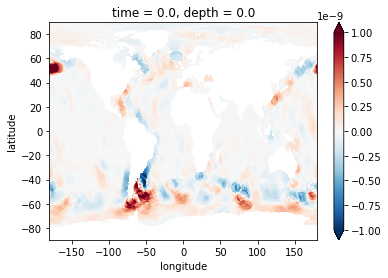

In [60]:
(ds_km['BPT'].isel(filter_scale=9) * ds_mask).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

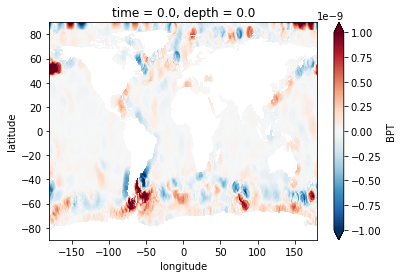

In [36]:
ds_deg['BPT'].isel(filter_scale=9).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

In [29]:
# Read wet data

ppdir1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

ds_wet = xr.open_dataset(ppdir1 + "OM4p25_JRA55_Vorticity_Budget_LatLon.nc")

ds_wet = ds_wet.rename({'x': 'longitude', 'y': 'latitude'})

print(ds_wet)

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440)
Coordinates:
    lon        (latitude, longitude) float64 ...
    lat        (latitude, longitude) float64 ...
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Data variables:
    beta_V     (latitude, longitude) float64 ...
    BPT        (latitude, longitude) float64 ...
    Mass_flux  (latitude, longitude) float64 ...
    eta_dt     (latitude, longitude) float64 ...
    Curl_dudt  (latitude, longitude) float64 ...
    Curl_taus  (latitude, longitude) float64 ...
    Curl_taub  (latitude, longitude) float64 ...
    Curl_Adv   (latitude, longitude) float64 ...
    Curl_diff  (latitude, longitude) float64 ...


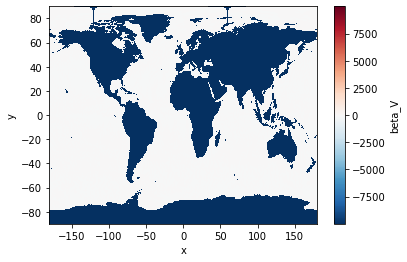

In [17]:
ds_wet['beta_V'].plot()

In [57]:
ds_mask = ds_deg['beta_V'].isel(filter_scale=0).copy()
ds_mask[:,:] = 1.

#ds_mask = ds_mask / ds_mask
#ds_mask = ds_mask.where(ds_mask != 10000., 1.)
ds_mask = ds_mask.where(ds_wet['beta_V'] != -9999.)

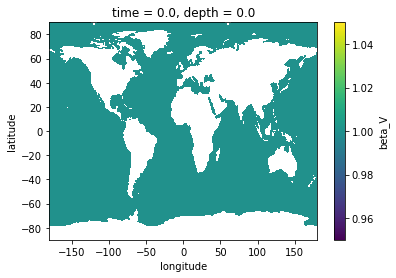

In [58]:
ds_mask.plot()

In [56]:
print(ds_mask)

<xarray.DataArray 'beta_V' (latitude: 720, longitude: 1440)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
    time       float64 0.0
    depth      float64 0.0
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9


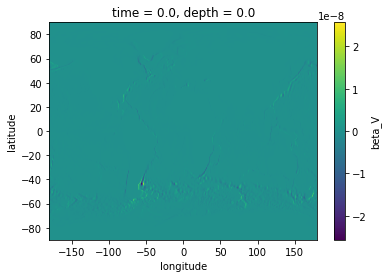

In [47]:
ds_mask = ds_deg['beta_V'].isel(filter_scale=0).copy()
ds_mask.plot(cmap='viridis')

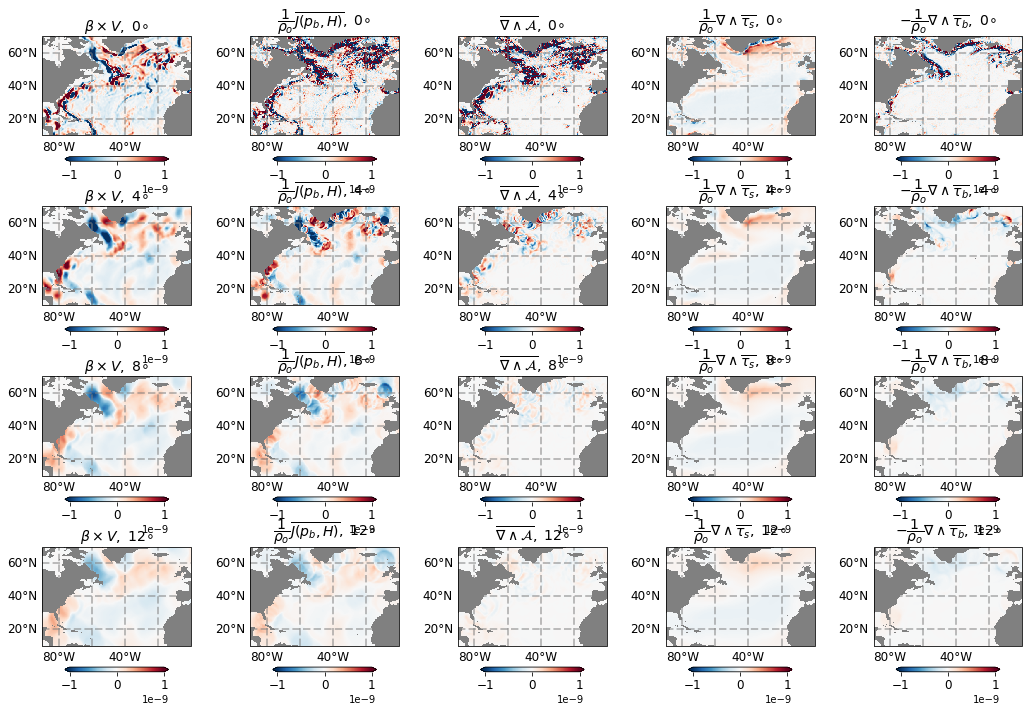

In [63]:
# Plot all 

ds = ds_deg.sel(longitude=slice(-90., 0.), latitude = slice(10, 70))
lat_lon_ext = [-90., 0., 10., 70.]
max_r = 1.e-9

grid1 = plt.GridSpec(4, 5, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,12])

for i in range(0,16,4):
    
    ax = fig.add_subplot(grid1[int(i/4), 0],projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['beta_V'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\beta \times V,$ ' + str(i)+'$\circ$' )
    #ds['beta_V'].isel(filter_scale=i).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
    
    ax = fig.add_subplot(grid1[int(i/4), 1], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['BPT'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ ' + str(i)+'$\circ$')
    
    ax = fig.add_subplot(grid1[int(i/4), 2], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['Curl_Adv'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\overline{\nabla \wedge \mathcal{A}},$ ' + str(i)+'$\circ$')
    
    ax = fig.add_subplot(grid1[int(i/4), 3], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['Curl_taus'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ ' + str(i)+'$\circ$')
    
    ax = fig.add_subplot(grid1[int(i/4), 4], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['Curl_taub'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ ' + str(i)+'$\circ$')

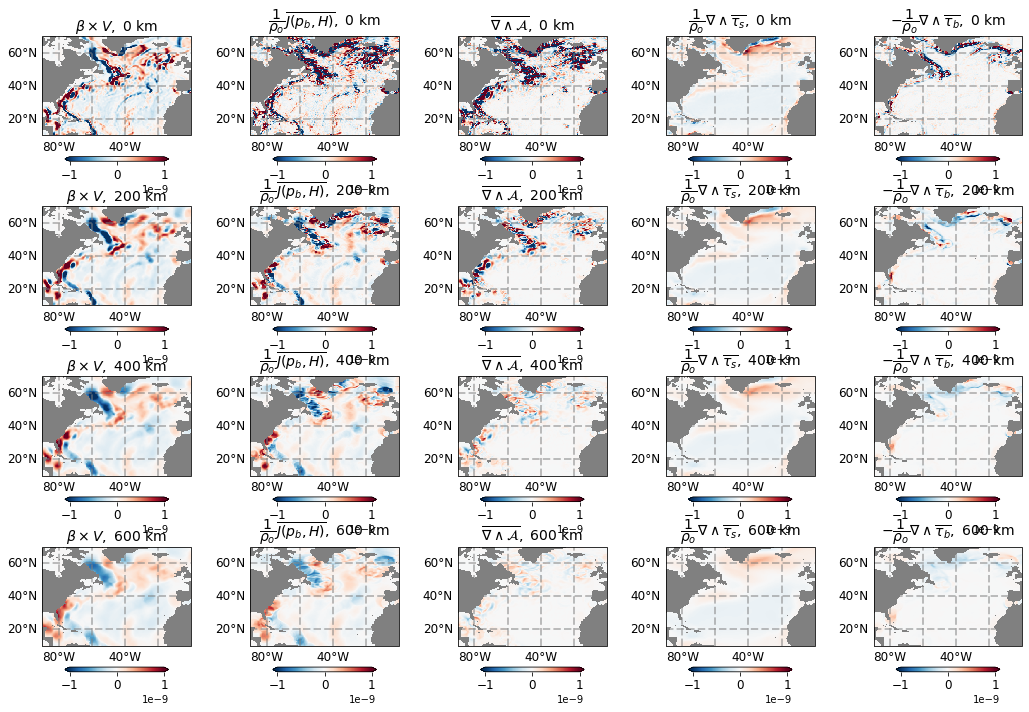

In [64]:
# Plot all 

ds = ds_km.sel(longitude=slice(-90., 0.), latitude = slice(10, 70))
lat_lon_ext = [-90., 0., 10., 70.]
max_r = 1.e-9

grid1 = plt.GridSpec(4, 5, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,12])

for i in range(0,8,2):
    
    ax = fig.add_subplot(grid1[int(i/2), 0],projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['beta_V'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\beta \times V,$ ' + str(i*100)+' km' )
    #ds['beta_V'].isel(filter_scale=i).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
    
    ax = fig.add_subplot(grid1[int(i/2), 1], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['BPT'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ ' + str(i*100)+' km')
    
    ax = fig.add_subplot(grid1[int(i/2), 2], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['Curl_Adv'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\overline{\nabla \wedge \mathcal{A}},$ ' + str(i*100)+' km')
    
    ax = fig.add_subplot(grid1[int(i/2), 3], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['Curl_taus'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ ' + str(i*100)+' km')
    
    ax = fig.add_subplot(grid1[int(i/2), 4], projection=ccrs.PlateCarree(),facecolor='grey')
    _ = plot_sec(ax, ds['Curl_taub'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ ' + str(i*100)+' km')